In [1]:
import sqlite3
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder

In [2]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

In [3]:
# Load .db file to df
conn = sqlite3.connect('data/failure.db')
df = pd.read_sql_query("SELECT * FROM failure", conn)

In [4]:
# Get a general overview of the dataset
df.head()

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,"Model 5, 2022",Blue,110.3 °C,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0
1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,"Model 3, 2022",Black,110.4 °C,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0
2,8c6a8e5b-d869-4665-b739-819c9e4a2070,"Model 3, 2022",Grey,110.3 °C,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0
3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,"Model 3, 2022",Black,110.4 °C,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0
4,10484506-1be0-4a86-8dbc-b8b2092b93b2,"Model 3, 2022",White,230.7 °C,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0


In [5]:
# Check how large the dataset is
df.shape

(10081, 14)

dataset has 100,81 rows and 14 columns

In [6]:
# then check the names of the columns
df.columns

Index(['Car ID', 'Model', 'Color', 'Temperature', 'RPM', 'Factory', 'Usage',
       'Fuel consumption', 'Membership', 'Failure A', 'Failure B', 'Failure C',
       'Failure D', 'Failure E'],
      dtype='object')

In [7]:
# Step 5: Get a statistical summary of the numerical columns in the data
df.describe()

,RPM,Fuel consumption,Failure A,Failure B,Failure C,Failure D,Failure E
count,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000
mean,1470.626823,679.472304,0.025692,0.018550,0.031049,0.024502,0.026386
std,487.502419,58.486101,0.158222,0.134935,0.173457,0.154608,0.160289
min,-2636.000000,598.500000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1418.000000,638.800000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1499.000000,668.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1609.000000,704.200000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2886.000000,904.800000,1.000000,1.000000,1.000000,1.000000,1.000000


<div class="alert alert-info" role="alert">
    
- Seems to have no missing data in the numerical features 
    
- But there are data quality issues in the RPM feature, as a negative RPM of 2636 is not possible.
    
- Average RPM is 1470 and the max is 2886

- Average Fuel consumption is 679, lowest is 598 and highest is 904
    
</div>

In [8]:
# Consider all negative RPM to be missing data.
df.loc[df['RPM'] < 0, 'RPM'] = np.NaN

In [9]:
# get a summary of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10081 entries, 0 to 10080
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Car ID            10081 non-null  object 
 1   Model             10081 non-null  object 
 2   Color             10081 non-null  object 
 3   Temperature       10081 non-null  object 
 4   RPM               9858 non-null   float64
 5   Factory           10081 non-null  object 
 6   Usage             10081 non-null  object 
 7   Fuel consumption  10081 non-null  float64
 8   Membership        9697 non-null   object 
 9   Failure A         10081 non-null  int64  
 10  Failure B         10081 non-null  int64  
 11  Failure C         10081 non-null  int64  
 12  Failure D         10081 non-null  int64  
 13  Failure E         10081 non-null  int64  
dtypes: float64(2), int64(5), object(7)
memory usage: 1.1+ MB


<div class="alert alert-info" role="alert">
    
Based on the information, we can tell that:
    
- There are 2 numerical features and 7 categorical features
  
- Dataset have 3 datatypes: float, int64 and object
    
- Now RPM has missing data which were the negative RPMs that were removed
    
- Membership feature has missing values 
    
- Temperature feature can be converted from string format to numerical format (from categorical to numerical)
        
</div>

In [10]:
# Taking a closer look at temperature feature 

# Select rows that doesn't contain celsius data in the temperature column
no_celsius = df[~df["Temperature"].str.contains('°C')] 
no_celsius.head()

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
10,d0145579-a871-4dd4-aee8-ac43183de196,"Model 7, 2021",White,230.8 °F,1782.0,"New York, U.S",High,849.5,Premium,0,0,0,0,0
11,c30a1d27-d6b5-454e-a96a-d9722408db5a,"Model 7, 2021",White,230.9 °F,1423.0,"New York, U.S",Low,801.8,Normal,0,0,0,0,0
17,1b9c9f59-33f0-4488-933b-af26d2a208a6,"Model 5, 2020",Red,230.9 °F,1410.0,"New York, U.S",High,742.4,Normal,0,0,0,0,0
24,4d69d500-7c92-403c-a7b8-ab3c2305d315,"Model 5, 2018",White,231.1 °F,1561.0,"New York, U.S",Low,675.5,Premium,0,1,0,0,0
29,e6529cf8-5d2f-431b-9f68-315c276bcd0f,"Model 3, 2018",White,231.1 °F,1693.0,"New York, U.S",Medium,645.4,Premium,0,0,0,0,0


<div class="alert alert-info" role="alert">
    
Since temperature feature contains both celsius and farenheit, can convert the farenheit to celsius to standardise them

</div>

In [11]:
def clean_temperature_column(row):
    
    """
    Returns a float from string input e.g. '230.8 °C' to 230.8
    
    If temperature is in farenheit, convert it to celsius first e.g. 100 farenheit to 37.78 celsius
    
    """
    
    temp = row['Temperature']                              
    
    if '°F' in temp:
        fahren = float(temp.replace('°F', ''))       # convert string to float e.g. '230.8 °F' to 230.8
        celsius = round((fahren - 32) * 5/9, 2)      # then do the conversion from fahrenheit to celsius, rounded off to 2 d.p
        
    else:
        celsius = float(temp.replace('°C', ''))
    
    return celsius
        
df["Temperature"] = df.apply(clean_temperature_column, axis=1)

In [12]:
df.describe()

,Temperature,RPM,Fuel consumption,Failure A,Failure B,Failure C,Failure D,Failure E
count,10081.000000,9858.000000,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000
mean,113.098318,1538.790221,679.472304,0.025692,0.018550,0.031049,0.024502,0.026386
std,4.657334,179.743469,58.486101,0.158222,0.134935,0.173457,0.154608,0.160289
min,110.000000,1168.000000,598.500000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,110.400000,1423.000000,638.800000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,111.330000,1503.000000,668.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,113.600000,1611.000000,704.200000,0.000000,0.000000,0.000000,0.000000,0.000000
max,230.700000,2886.000000,904.800000,1.000000,1.000000,1.000000,1.000000,1.000000


<div class="alert alert-info" role="alert">
        
Average Temperature is 113, lowest is 110 and highest is 230 (likely to have outliers in the column)
        
</div>

In [13]:
# Checking for missing values

In [14]:
# show the number of missing values in each feature
print('Number of missing values for each column:')
df.isnull().sum()

Number of missing values for each column:


Car ID                0
Model                 0
Color                 0
Temperature           0
RPM                 223
Factory               0
Usage                 0
Fuel consumption      0
Membership          384
Failure A             0
Failure B             0
Failure C             0
Failure D             0
Failure E             0
dtype: int64

In [15]:
# Then show the percentage of missing data only for features with such missing data
print('Percentage of missing data:')
null_df = df.isnull()
null_df.loc[:, null_df.any()].mean().round(4).mul(100).sort_values(ascending=False)

Percentage of missing data:


Membership    3.81
RPM           2.21
dtype: float64

<div class="alert alert-info" role="alert">
    
- 2 features with missing data
    
- Can use missing data imputation to fill in the missing values instead of removing the rows entirely since the percentage of missing values is low. 
    
- Can use mode imputation for membership (categorical feature) and median/mean imputation for rpm (numerical feature) depending on skewness
       
</div>

In [16]:
# Select all numerical data
num_col = df.select_dtypes(exclude='object').copy()

# Select all categorical data (dont need ID column)
cat_col = df.select_dtypes(exclude=['int64','float64']).copy()
cat_col.drop('Car ID', axis=1, inplace=True)

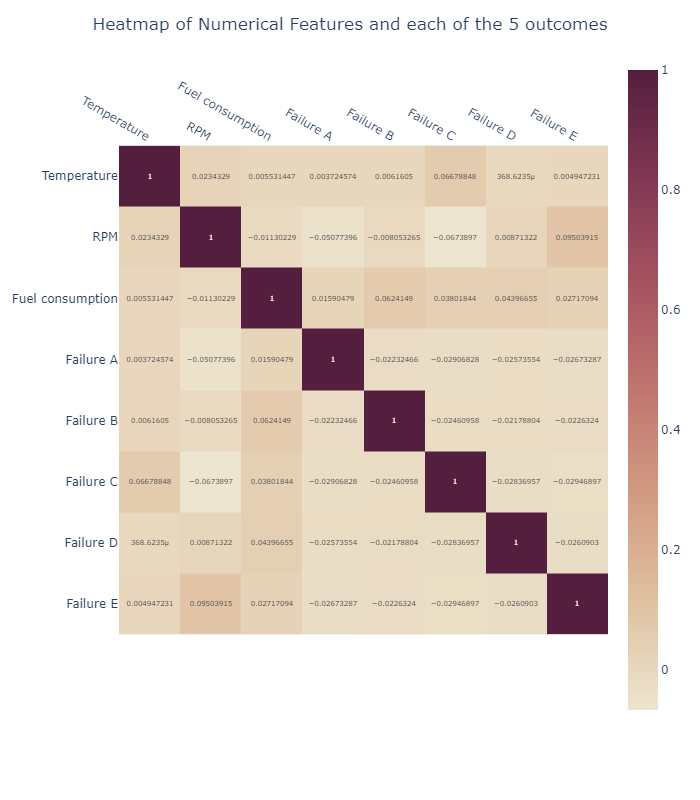

In [17]:
# Heatmap to study the relationship between numerical features and outcomes.
corr = num_col.corr()
fig = px.imshow(corr, color_continuous_scale = 'brwnyl', text_auto = True)
fig.update_xaxes(side="top")
fig.update_layout(title='Heatmap of Numerical Features and each of the 5 outcomes', height=800, title_x=0.5)
fig.show("png")

<div class="alert alert-info" role="alert">
    
Based on the heatmap:

- There are no strong correlations in any of the numerical features with the 5 failure types (outcomes)
    
- Means that a change in one feature is unlikley to have a significant effect on other features 
    
- Also means that it would be more difficult to build an effective model
    
- But there are some very weak correlations observed:
     - Temperature and Failure C (~0.067)
     - Fuel consumption and and Failure B (~0.062)
     - RPM and Failure E (~0.05)
    
</div>

In [18]:
# Histograms to check the distribution and skewness of the features
def make_histograms(df, row, col, text):
    
    """
    Generate histogram for each given variable using subplots
    """
    
    # Create a subplot grid
    fig = make_subplots(rows=row,
                        cols=col,
                        subplot_titles=list(df.columns),
                        vertical_spacing=0.4)

    # Create a histogram for each column
    for i,col in enumerate(df.columns):
        fig.add_trace(go.Histogram(x=df[col],name=col),row=i//4+1, col=i%4+1)

    fig.update_layout(title=f'Distribution of each {text}', showlegend=False, title_x=0.5)
    fig.show("png")

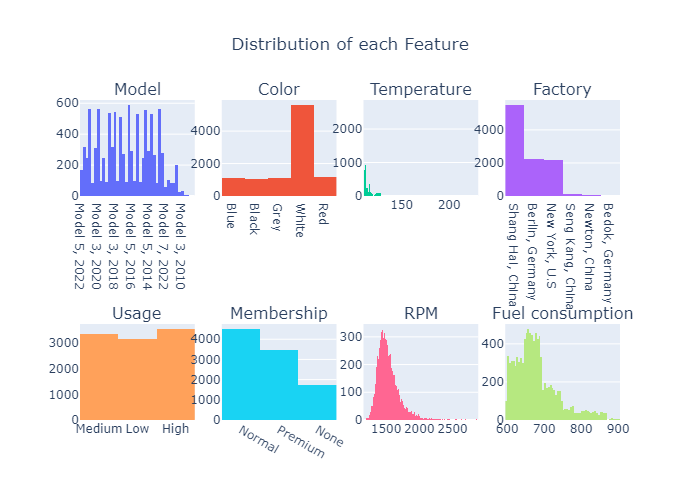

In [19]:
features = ['Model', 'Color', 'Temperature', 'Factory', 'Usage', 'Membership', 'RPM', 'Fuel consumption']
features_df = df[features].copy()

make_histograms(features_df, 2, 4, 'Feature')

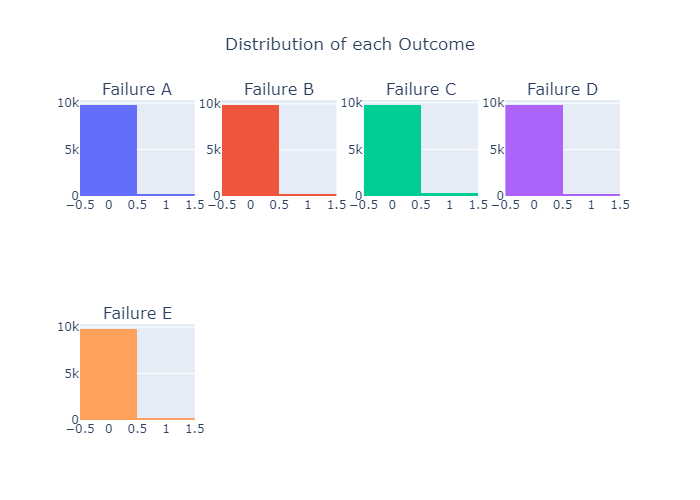

In [20]:
outcomes = ['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E']
outcomes_df = df[outcomes]
make_histograms(outcomes_df, 2, 4, 'Outcome')

<div class="alert alert-info" role="alert">
    
Based one the charts:
    
- White is the most common car color
    
- Most cars are manufactured in Shanghai, China (5518)
    
- There is a uniform distribution of car usage (3360 medium, 3162 low, 3559 high).
    
- The most common membership is Normal. 
    
- RPM is positively skewed. 
    
- Fuel Consumption might also be positively skewed but there could be extreme outliers that are affecting the distribution
        
- Since RPM, Fuel Consumption is skewed, can use z-score normalisation when performing feature scaling.
        
- Dataset is very imbalanced. For example, For Failure A, there are 9822 failures but only 259 non-failures. 
    
  - Could resample the dataset when building the model but none of the resampling methods (e.g. SMOTE) I researched on could work with our dataset with 5 target variables.
 
</div>

<div class="alert alert-info" role="alert">
    
- We have a multi-label classification problem with a very imbalanced dataset and resampling methods wouldn't work.
    
- Could experiment to see if its possible to convert our multi-label classification problem into a binary classification problem instead
    
- Could try summing up all the 5 failures and generalise them into 1 failure column but it wouldnt work if there are any cars with more than 1 Failure Type
     
</div>

In [26]:
# Sum up all the 5 failures into 1 failure column.
df['Failure'] = df['Failure A'] + df['Failure B'] + df['Failure C'] + df['Failure D'] + df['Failure E']

# Check if there any cars have more than 1 failure type
df[df['Failure']  > 1]

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Failure


<div class="alert alert-info" role="alert">
    
- None of the cars have more than one Failure Type. Might be possible to combine all failure types into a general failure outcome.
    
- But not sure if i'm going off the scope of this assessment so i will build models for both multi-label and single-label classification
    
</div>

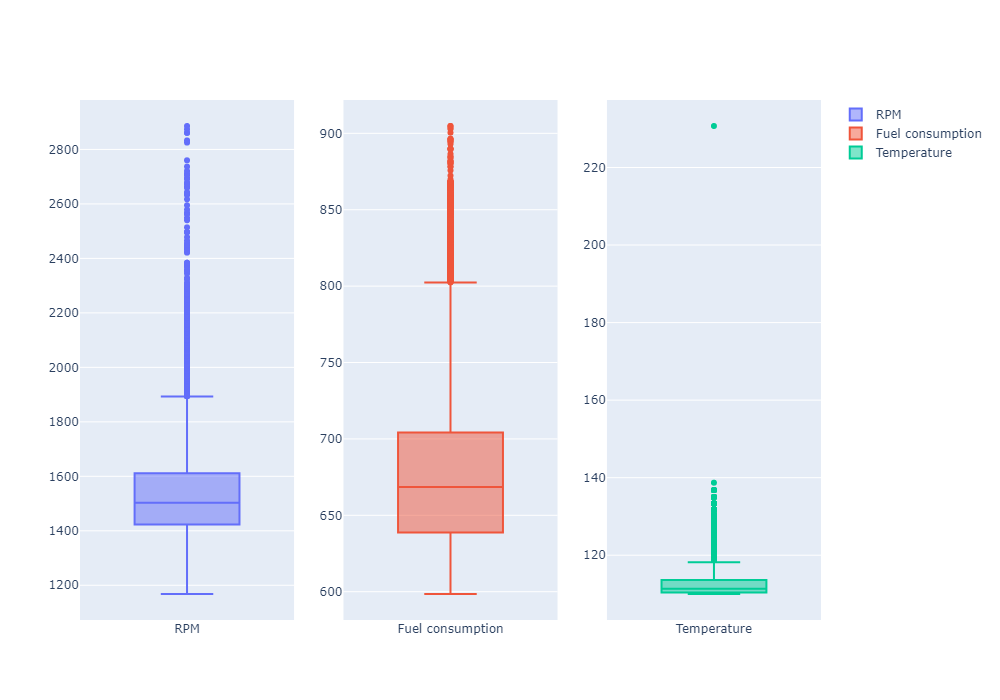

In [22]:
# Boxplots for the 3 numerical features (RPM and fuel consumption) to understand the outliers

fig = make_subplots(rows=1, cols=3, shared_yaxes=False)

fig.add_trace(go.Box(y=df['RPM'], name='RPM'), row=1, col=1)                            # create first boxplot
fig.add_trace(go.Box(y=df['Fuel consumption'], name='Fuel consumption'), row=1, col=2)  # create first boxplot
fig.add_trace(go.Box(y=df['Temperature'], name='Temperature'), row=1, col=3)            # create first boxplot

fig.update_layout(height=700, width=1000)
fig.show("png")

<div class="alert alert-info" role="alert">
    
From the boxplots, we have found that:
    
- All 3 numerical features have a number of outliers
- Temperature also has an extreme outlier (230.7 degrees)
- Can use log transformation to deal with the effects of these outliers on model performance
 
</div>

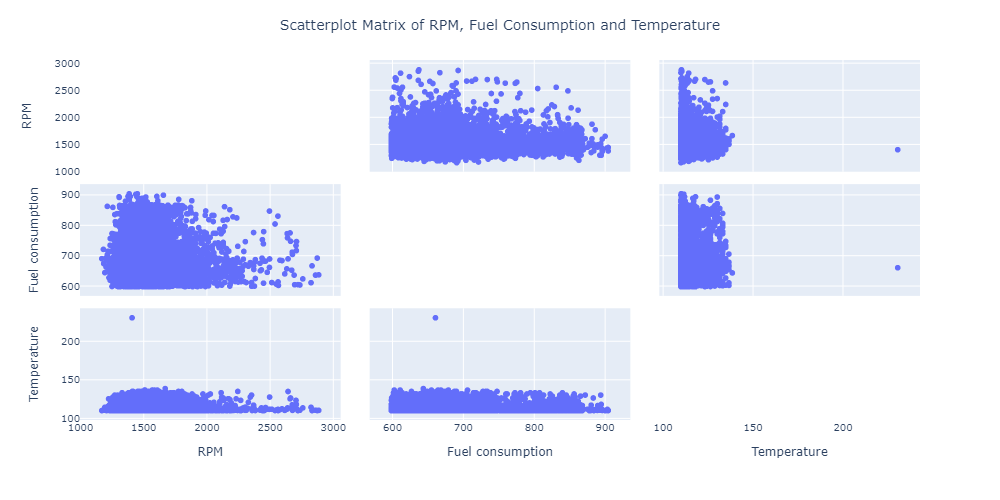

In [23]:
# Scatterplot matrix to show the relationships between the two numerical of numerical features in the dataset
num_features = ['RPM', 'Fuel consumption', 'Temperature']

fig = px.scatter_matrix(df, dimensions=num_features)
fig.update_traces(diagonal_visible=False)
fig.update_layout(title='Scatterplot Matrix of RPM, Fuel Consumption and Temperature',
                  font=dict(size=10),
                  title_x=0.5,
                  height=500,
                  width=1000) 
fig.show("png")

<div class="alert alert-info" role="alert">
    
From the scatterplot, we can tell that:
    
- There are no obvious association between any two number features
- There is a cluster of low RPM and low fuel consumption which seems like an obvious observation since lower RPM uses lower fuel 
    
</div>